In [26]:
import os
import pandas as pd
import numpy as np
import math
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans

from pyInfinityFlow.InfinityFlow_Utilities import move_features_to_silent
from pyInfinityFlow.InfinityFlow_Utilities import anndata_to_df
from pyInfinityFlow.InfinityFlow_Utilities import read_fcs_into_anndata
from pyInfinityFlow.InfinityFlow_Utilities import apply_logicle_to_anndata

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/2023_02_28_pyinfinityflow_cellharmony_mouse_lung/")

In [27]:
path_output_results = "output/python3_cellharmony_r7_infinity_flow_adt_alone/"

In [28]:
# Helper functions
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))


def marker_finder(input_df, groups):
    """
    Function to find pearson correlation coefficient values and p-values for 
    the given data and groups for groups to test. The function will perform a 
    Pearson correlation of the input_df feature values to an "idealized" 
    group specific expression vector, where each observation in a given group
    is set to a value of 1, and the observations in other groups are set to 0.
    Arguments
    ---------
    input_df : pandas.DataFrame
        DataFrame with observations as index and features as columns (Required)
    
    groups : list[str]
        List-like of specified groups corresponding to observations from the 
        input_df. The order of groups should match the order in input_df.index
        (Required)
    Returns
    -------
    r_df
        a pandas.DataFrame containing the pearson
        correlation coefficient values for each marker to the idealized vector
        for each cluster.
    """
    ideal_vectors = pd.get_dummies(groups)
    ideal_vectors.index = input_df.index.values
    degrees_f = input_df.shape[0] - 2
    r_df = pearson_corr_df_to_df(input_df, ideal_vectors)
    # t_df = r_df*np.sqrt(degrees_f) / np.sqrt(1-(r_df**2))
    # p_df = t_df.applymap(lambda x: t.sf(abs(x), df=degrees_f)*2)
    return(r_df)

def map_min_max(input_array, input_min, input_max):
    tmp_scaler = 1 / (input_max - input_min)
    input_array = np.array(input_array)
    input_array[input_array < input_min] = input_min
    input_array[input_array > input_max] = input_max
    return(tmp_scaler * (np.array(input_array) - input_min))

In [31]:
### Reading in the data
previous_groups = pd.read_table("input/groups.250k-header-Mm_salomonis.txt",
    header=None, index_col=0)
previous_groups.columns = ["cluster", "group"]
previous_groups.index.name = None

rna_centroids = pd.read_table(\
    "input/mouse_lung_dataset_rna_seq_expression_centroids.txt",
    index_col=0).iloc[1:,1:].T

inflow_data = pd.read_feather(\
    "input/infinity_flow_object_logicle_normalized.fea").set_index("index")
inflow_data.index.name = None
inflow_data.columns = [item.split(":")[0] for item in inflow_data.columns.values]

inflow_data

,33D1,Allergin-1,B7-H4,CD103,CD105,CD106,CD107a (Lamp-1),CD107b (Mac-3),CD115,CD117 (c-kit),...,Isotype_mIgM,Isotype_rIgG1,Isotype_rIgG2a,Isotype_rIgG2b,Isotype_rIgG2c,Isotype_rIgM,SSC-A,SSC-H,SSC-W,Time
F0:42,0.256836,0.225614,0.268800,0.252013,0.253418,0.250318,0.386350,0.390262,0.268330,0.247289,...,0.252780,0.261759,0.263874,0.254871,0.251721,0.249204,18647.160156,15508.0,0.605011,0.250950
F0:49,0.244337,0.226113,0.260895,0.257499,0.250600,0.255052,0.359803,0.343378,0.253853,0.247803,...,0.253209,0.253416,0.255803,0.254704,0.260996,0.249246,13851.860352,12078.0,0.599890,0.250959
F0:66,0.251148,0.214808,0.260347,0.258930,0.263331,0.261094,0.311523,0.277898,0.259640,0.260761,...,0.259513,0.257171,0.246066,0.253466,0.265565,0.249684,8098.290039,7779.0,0.589416,0.250980
F0:101,0.239796,0.206447,0.239571,0.241220,0.242878,0.249397,0.263170,0.251546,0.244354,0.250205,...,0.252524,0.243971,0.235881,0.248081,0.243070,0.246459,3858.360107,3620.0,0.591963,0.251025
F0:111,0.252691,0.234568,0.253403,0.259853,0.305881,0.252402,0.301897,0.271699,0.253863,0.278328,...,0.252889,0.252317,0.254386,0.254186,0.251790,0.251151,3615.040039,4081.0,0.571965,0.251029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F262:85087,0.251982,0.224152,0.256543,0.255280,0.252090,0.257777,0.255839,0.253132,0.252790,0.252984,...,0.247124,0.250009,0.251874,0.249804,0.253150,0.245868,2596.729980,2525.0,0.588095,0.328551
F262:85090,0.255085,0.221619,0.260115,0.253290,0.295983,0.254898,0.336085,0.310801,0.254434,0.271410,...,0.250648,0.254520,0.254221,0.255245,0.252403,0.250021,5376.740234,4396.0,0.606857,0.328554
F262:85111,0.246240,0.208893,0.247005,0.247774,0.245697,0.244351,0.246383,0.246048,0.250484,0.249695,...,0.248652,0.247619,0.247070,0.246613,0.247951,0.248754,1294.020020,1278.0,0.586414,0.328564
F262:85128,0.257196,0.226058,0.248320,0.253692,0.321033,0.255535,0.293443,0.272882,0.256889,0.300020,...,0.251963,0.253315,0.254267,0.254745,0.251249,0.251007,1786.980103,1773.0,0.585916,0.328582


In [32]:
### Map flow channel names to encoding gene names from RNA-seq
map_gene_names = pd.read_table(\
    "input/map_antibody_name_to_source_gene_name.txt",
    header=None)
map_gene_names.index.name = None
map_gene_names.columns = ["Flow", "RNA"]

map_gene_names = map_gene_names.loc[\
    map_gene_names["RNA"].isin(rna_centroids.columns.values)]
map_gene_names = map_gene_names.loc[\
    map_gene_names["Flow"].isin(inflow_data.columns.values)]

map_gene_names
# 
# inflow_data = inflow_data.loc[:,map_gene_names.index.values]
# inflow_data.columns = map_gene_names.values
# inflow_data

,Flow,RNA
0,33D1,Clec4a4
1,Allergin-1,Milr1
2,B7-H4,Vtcn1
3,CD103,Itgae
4,CD105,Eng
...,...,...
240,TREM-like 4,Treml4
241,Tim-1,Havcr1
242,Tim-2,Timd2
243,Tim-3,Havcr2


In [33]:
### CellHarmony centroid classification
# Normalize using zscore
ref_data = pd.DataFrame(\
    zscore(rna_centroids.loc[:,map_gene_names["RNA"]].values.astype(np.float32)),
    index=rna_centroids.index.values,
    columns=map_gene_names.index.values)
que_data = pd.DataFrame(\
    zscore(inflow_data.loc[:,map_gene_names["Flow"]].values.astype(np.float32)),
    index=inflow_data.index.values,
    columns=map_gene_names.index.values)


In [36]:
# Calculate correlations
centroid_cors = pearson_corr_df_to_df(que_data.T, ref_data.T)
top_cors_df = pd.DataFrame({\
        "top_cluster": centroid_cors.idxmax(axis=1),
        "rho": centroid_cors.max(axis=1)},
    index=centroid_cors.index.values)

top_cors_df

,top_cluster,rho
F0:42,IM,0.323309
F0:49,AM,0.451201
F0:66,iMON,0.350603
F0:101,B,0.540845
F0:111,EPC,0.509947
...,...,...
F262:85087,B,0.455234
F262:85090,CAP1,0.501787
F262:85111,NK,0.454743
F262:85128,CAP1,0.615519


In [38]:
previous_groups_series = pd.Series(\
    previous_groups["group"].values, 
    index=[item.replace("__", ":") for item in previous_groups.index.values])

previous_groups_series

F122:94670          B
F201:90232          B
F43:96823           B
F167:71157          B
F148:94732          B
               ...   
F175:56894      CD4_T
F146:98537       cDC1
F1:14108        CD4_T
F235:24257       ASMC
F15:21577     AT1/AT2
Length: 2630000, dtype: object

In [42]:
(previous_groups_series.loc[top_cors_df.index.values].values == top_cors_df["top_cluster"].values).sum()

1553546

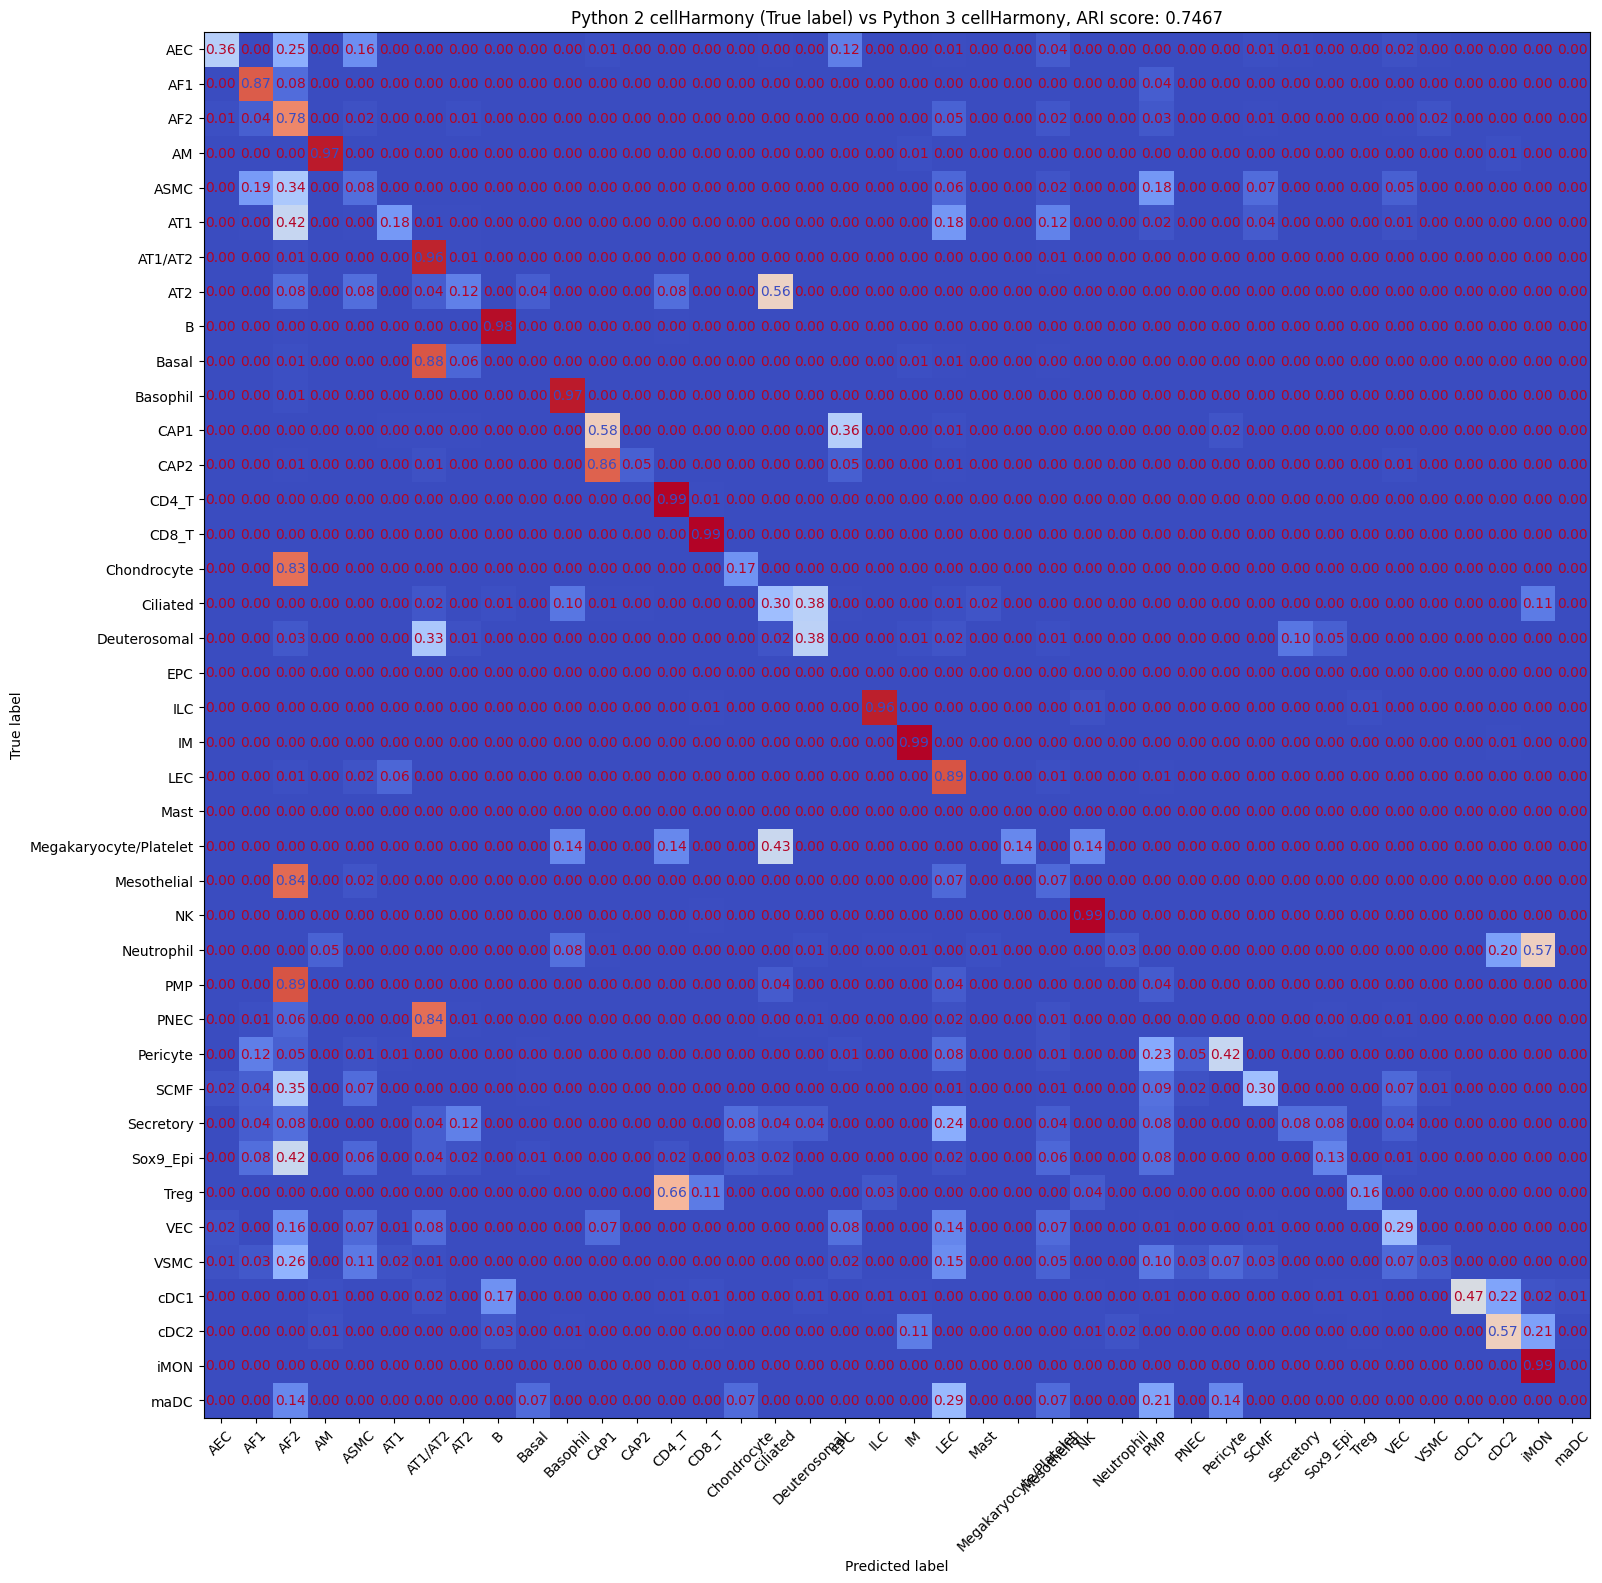

In [47]:
ari_score = adjusted_rand_score(\
    previous_groups_series.loc[top_cors_df.index.values].values,
    top_cors_df["top_cluster"].values)

fig, ax = plt.subplots(figsize=(18,18))

ax.set_title("Python 2 cellHarmony (True label) vs Python 3 cellHarmony, "\
    "ARI score: {:.4f}".format(ari_score))

ConfusionMatrixDisplay.from_predictions(\
    y_true=previous_groups_series.loc[top_cors_df.index.values].values,
    y_pred=top_cors_df["top_cluster"].values,
    # labels=order_ari_groups.index.values,
    xticks_rotation=45,
    ax=ax,
    cmap="coolwarm",
    normalize="true",
    values_format=".2f",
    colorbar=False)


In [44]:
adjusted_rand_score(\
    previous_groups_series.loc[top_cors_df.index.values].values,
    top_cors_df["top_cluster"].values)

0.7467048082568467

In [51]:
adjusted_rand_score(\
    previous_groups_series.loc[\
        top_cors_df.loc[top_cors_df["rho"] > 0.4].index.values].values,
    top_cors_df.loc[\
        top_cors_df.loc[top_cors_df["rho"] > 0.4].index.values, 
        "top_cluster"].values)

0.870038169318368

,top_cluster,rho
F0:42,IM,0.323309
F0:49,AM,0.451201
F0:66,iMON,0.350603
F0:101,B,0.540845
F0:111,EPC,0.509947
...,...,...
F262:85087,B,0.455234
F262:85090,CAP1,0.501787
F262:85111,NK,0.454743
F262:85128,CAP1,0.615519


In [53]:
# Plot population predictions over UMAP
umap_coors = pd.read_table("input/"\
    "umap_coordinates_leiden_res_4_mindist_0_2_epochs_500.tsv").set_index("UID")

umap_coors

,umap-x,umap-y
UID,,
F0:42,-6.481632,0.312579
F0:49,-5.855502,3.259517
F0:66,-13.077271,7.931735
F0:101,7.832776,-1.292134
F0:111,0.556521,7.392465
...,...,...
F262:85087,5.544703,5.317891
F262:85090,2.234828,4.379427
F262:85111,-2.167350,14.509268


In [60]:
tmp_cluster = rna_centroids.index.values[0]

top_cors_df.loc[top_cors_df["top_cluster"] == tmp_cluster].index.values

,top_cluster,rho
F0:1249,Pericyte,0.269296
F0:4764,Pericyte,0.318209
F0:5898,Pericyte,0.248561
F0:6765,Pericyte,0.367008
F0:8615,Pericyte,0.285370
...,...,...
F262:61208,Pericyte,0.394019
F262:61662,Pericyte,0.296336
F262:67563,Pericyte,0.284096
F262:82099,Pericyte,0.310068


In [ ]:
### Make test plots of cellharmony clusters over umap
# Plot louvain communities
sample_1e5 = pd.Series(list(range(umap_coors.shape[0]))).sample(100000).sort_values().values
for tmp_cluster in rna_centroids.index.values:

    cluster_cells_py2 = previous_groups_series[\
        previous_groups_series == tmp_cluster].index.values

    cluster_cells_py3 = top_cors_df.loc[\
        top_cors_df["top_cluster"] == tmp_cluster].index.values

    plt.close("all")
    fig, ax = plt.subplots(1, 2, figsize=(24,12))

    ax[0].scatter(\
        umap_coors.obs.iloc[sample_1e5,:]['umap_x'], 
        umap_coors.obs.iloc[sample_1e5,:]['umap_y'], 
        color="gray", 
        alpha=0.01,
        edgecolors=None, 
        s=4)
    ax[0].scatter(\
        umap_coors.obs.loc[cluster_cells, 'umap_x'], 
        umap_coors.obs.loc[cluster_cells, 'umap_y'],
        color="red",
        edgecolors=None, 
        alpha=0.05)
        # c=top_cell_correlations.loc[\
        #     top_cell_correlations["pred"] == "LT-HSC_Mllt3", "rho"],
        # cmap="coolwarm")


    # ax[0].set_xlim(umap_bounds.iloc[0,:].values)
    # ax[0].set_ylim(umap_bounds.iloc[1,:].values)
    ax[0].spines.right.set_visible(False)
    ax[0].spines.top.set_visible(False)
    ax[0].spines.bottom.set_visible(False)
    ax[0].spines.left.set_visible(False)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.title("Louvain Cluster {}".format(tmp_cluster))
    plt.savefig("output/python3_cellharmony_r7_infinity_flow_adt_alone/"\
        "que_com_over_umap/"\
        "louvain_community_cluster_{}.png".format(tmp_cluster))

In [61]:
# Save groups determined from python3 version
top_cors_df.to_csv("output/python3_calculated_groups.csv", header=True, index=True, index_label="UID")